# **BUSI 488 / COMP 488 Data Science in the Business World**
## *Spring 2023*  
Daniel M. Ringel  
Kenan-Flagler Business School  
*The University of North Carolina at Chapel Hill*  
dmr@unc.edu

## Class 16 - Model Performance and Generalization Errors

*March 7, 2023*  
Version 1.0


# Today's Agenda

1. **Empirical Setting**
2. **Support Vector Machines**
3. **Cross-Validation**
4. **Hyperparameter tuning**
5. **Confusion Matrices**
6. **Binary Outputs vs. Probabilities**
7. **ROC Curves and AUC**
8. **Algorithmic Bias**


## Prep-Check:
- Reviewed Python Notebook from Class 15

# Today's Marketing Problem: From Lab to the Real-World!
###**A Fintech wants to automate the loan approval process in real-time...** 
###**...based on information that applicants provide about themselves online.**  

1. How to find the best model? 
2. How can the Fintech be more certain that their model actually works in the real-world (i.e., on new data)?
3. How can the Fintech investigate algorithmic bias?

![Lab vs Real-World](https://upmic.files.wordpress.com/2013/05/real-vs-movie-scientist2.png)





# 1 Empirical Setting: ***Customer Eligibility for a Loan***

[*Based on an Analytics Vidhya practice competition*](https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/)

A Fintech wants to automate the loan eligibility process (in real time) based on the details that applicants provide in their online application. These details are:

- Gender
- Marital Status
- Education
- Number of Dependents
- Income
- Loan Amount
- Credit History and others. 

To automate this process, the Fintech needs to assign applicants to either being eligible for the requested loan (amount), or not. You are provided with a training dataset in which the loan eligibility is marked. 
The dataset contains the following variables:

| Variable          	| Description                     	|
|-------------------	|---------------------------------	|
| Loan_ID           	| Unique Loan ID                  	|
| Gender            	| Male/ Female                    	|
| Married           	| Applicant married (Y/N)         	|
| Dependents        	| Number of dependents            	|
| Education         	| Graduate/ Under Graduate        	|
| Self_Employed     	| Self employed (Y/N)             	|
| ApplicantIncome   	| Applicant income                	|
| CoapplicantIncome 	| Coapplicant income              	|
| LoanAmount        	| Loan amount in thousands        	|
| Loan_Amount_Term  	| Term of loan in months          	|
| Credit_History    	| credit history meets guidelines 	|
| Property_Area     	| Urban/ Semi Urban/ Rural        	|
| Loan_Status       	| Loan approved (Y/N)             	|

You can download the dataset ***loan_train.csv*** from CANVAS along with the notebook of this class.

## 1.1 Mount our Google Drive

In [ ]:
#0a Mount Drive
from google.colab import drive
drive.mount('/content/gdrive')

#0b Change into directory where data files are
%cd /content/gdrive/MyDrive/488/Class16

#0c show files in current directory
!ls # view the files in the current directory of the notebook environment

Mounted at /content/gdrive
/content/gdrive/MyDrive/488/Class16
488_2023_Class16.ipynb	loan_train.csv


## 1.2 Preprocess Data in one Step!

We create a function that takes care of all the preprocessing steps for us.  

***What is the advantage of doing so?***

In [ ]:
# 1a Import some libraries that you will need for this step
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

# 2 Let's create two functions that help us with the preprocessing to make it faster and easier to execute

# 2a Outlier Detection (we will call this function within our preprocessing function that we define next in 2b)
'This function can be used on any dataset to return a list of index values for the outliers (based on standard deviation)'
'Only appropriate for numerical features'
def get_outliers(data, columns, nsd=3):
    # we create an empty list
    outlier_idxs = []
    for col in columns:
        elements = data[col]
        # we get the mean value for each column
        mean = elements.mean()
        # and the standard deviation of the column
        sd = elements.std()
        # we then get the index values of all values higher or lower than the mean +/- nsd standard deviations
        outliers_mask = data[(data[col] > mean + nsd*sd) | (data[col]  < mean  - nsd*sd)].index
        # and add those index values to our list
        outlier_idxs  += [x for x in outliers_mask]
    return list(set(outlier_idxs))

# 2b Put all the preprocessing from class 04 into a function
'Function that receives the loan eligibility raw data'
'as well as the imputation strategies for categorical and numerical features'
'and runs all preprocessing steps'
'Outputs a data object that contains features and response variable'
def prepro(df,numimp,catimp):
      #2b1 The first column (Loan_ID) is not informative to our task. So let's drop it!
      df=df.drop(['Loan_ID'],axis=1)

      #2b2 Make your work easy: Automatically identify which features are numeric and which are categorical. 
      # To do so, create two indices that hold the colum names of our data set that are numerical and categorical, respectively
      # Make sure that you do not include our response variable here, since this is just about features!
      numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
      categorical_features = df.select_dtypes(include=['object', 'category']).drop(['Loan_Status'], axis=1).columns

      #2b3 What about Credit_History? Should that not be a categorical variable?
      numeric_features=numeric_features.drop('Credit_History')
      categorical_features=categorical_features.insert(6, 'Credit_History') 
    
      #2b4 Now typecast all variables that are categorical as type "category"
      for col in categorical_features.tolist():
              df[col] = df[col].astype('category')

      #2b5 Don't forget to also typecast our response variable as category
      df['Loan_Status'] = df['Loan_Status'].astype('category')   

      #2b6 Let's identify and remove outliers for the numerical variables using the function we created in 2a above
      outs = get_outliers(df, numeric_features)
      df = df.drop(outs, axis = 0)

      #2b7a Now you need to impute missing numerical values. What imputation strategy will you choose?
      imputer = SimpleImputer(missing_values = np.nan, strategy = numimp)
      imputer = imputer.fit(df[numeric_features.tolist()])
      df[numeric_features.tolist()] = imputer.transform(df[numeric_features.tolist()])

      #2b7b Now you need to impute missing categorical values. 
      imputercat = SimpleImputer(missing_values = np.nan, strategy = catimp)
      imputercat = imputercat.fit(df[categorical_features.tolist()])
      df[categorical_features.tolist()] = imputercat.transform(df[categorical_features.tolist()])
      df['Credit_History'] = df['Credit_History'].astype('category')   # imputer set type back to numeric, so we correct it again

      #2b8 Create a new dataframe X that includes only our feature variables
      feat = df.loc[:, df.columns != 'Loan_Status']

      #2b9 Create a new dataframe y that includes only our 
      lab = df.Loan_Status

      #2b10 Now you need to one hot encode the categorical features to make them machine readable. 
      feat = pd.get_dummies(feat)

      #2b11 And re-code the response variable using a dictionary and replace
      repmap={"Y": 1, "N": 0}
      lab.replace(repmap, inplace=True)

      #2b12 Feature engineer Household_Income_log (why log?) and add it to our features (X)
      feat['Household_Income_log']=np.log(feat.ApplicantIncome + feat.CoapplicantIncome)

      #2b13 Feature engineer EMI and add it to our features (X)
      # incorrect --> feat['EMI']=(feat['LoanAmount']*0.06*(1.06**feat['Loan_Amount_Term']))/(12*(1.06**(feat['Loan_Amount_Term']-1)))
      r = 0.06/12
      feat['EMI']=np.ceil(feat['LoanAmount']*1000*r*((1+r)**feat['Loan_Amount_Term'])/((1+r)**feat['Loan_Amount_Term']-1)*100)/100

      #2b14 Append our two new features to our numerical features
      numeric_features=numeric_features.insert(len(numeric_features),'EMI') 
      numeric_features=numeric_features.insert(len(numeric_features),'Household_Income_log') 
      
      #2b15 Return the features (feat) and labels (lab)
      return feat, lab, numeric_features

In [ ]:
# 3 Load data file into a pandas dataframe
data = pd.read_csv("loan_train.csv") # parse to a Pandas DataFrame using pd.read_csv()
display(f"Observations in Dataset: {len(data)}")

# 4 Call preprocessing function and pass it the dataframe as well as the imputation strategies for (1) numerical and (2) categorical features
data = prepro(data,'median','most_frequent') 

# 5 Separate features (X) and labels (y) from data object
X=data[0]
y=data[1]

# 6 Get numerical features
numeric_features = data[2]

# 7 Verify that it worked
display(X.head())
display(y.head())
display(numeric_features)
display(f"Observations after Preprocessing: {len(X)}")

'Observations in Dataset: 614'

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,...,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Credit_History_0.0,Credit_History_1.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Household_Income_log,EMI
0,5849.0,0.0,126.0,360.0,0,1,1,0,1,0,...,0,1,0,0,1,0,0,1,8.674026,755.44
1,4583.0,1508.0,128.0,360.0,0,1,0,1,0,1,...,0,1,0,0,1,1,0,0,8.714568,767.43
2,3000.0,0.0,66.0,360.0,0,1,0,1,1,0,...,0,0,1,0,1,0,0,1,8.006368,395.71
3,2583.0,2358.0,120.0,360.0,0,1,0,1,1,0,...,1,1,0,0,1,0,0,1,8.505323,719.47
4,6000.0,0.0,141.0,360.0,0,1,1,0,1,0,...,0,1,0,0,1,0,0,1,8.699515,845.37


0    1
1    0
2    1
3    1
4    1
Name: Loan_Status, dtype: int64

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'EMI', 'Household_Income_log'],
      dtype='object')

'Observations after Preprocessing: 578'

# 2. Predicting Loan Eligibility using a Support Vector Machine

**SVMs in a  Nutshell**: In machine learning, support-vector machines (SVMs, also support-vector networks) are ***supervised learning models*** with associated learning algorithms that analyze data used for ***classification*** and ***regression*** analysis.

- Representation of the examples (observations) as points in space ...
- ... mapped so that the examples of the separate categories are divided by a clear gap ...
- ... that is as wide as possible. 

New examples are then mapped into that same space and predicted to belong to a category based on the side of the gap on which they fall. 

![SVM](https://mapxp.app/BUSI488/svm3.png)


If you would like to read-up on more details about SVMs and how the work, take a look at the following tutorial:
[SVM tutorial](https://towardsdatascience.com/an-introduction-to-support-vector-machine-3f353241303b)



## 2.1 NOT SO FAST! Feature Scaling First

We want to impose equal weights on our features and many ML models assume standardized data.

To do so:

1. We can create a function to rescale our data so that the mean is zero and standard deviation is unity (1) on all features, or we can use a minmaxscaler (with range 0 to 1).
2. Apply that function to our numerical data
3. Describe our numerical data afterwards

**!** A good exercise would be to research what MinMaxScaler and StandardScaler do (both are from the scikit-learn library).

In [ ]:
#1 This function loops through columns in a feature set and defines a predefined scaler to each
def scale_numeric(features, numeric_features, scaler):
    for col in numeric_features.tolist():
        features[col] = scaler.fit_transform(features[col].values.reshape(-1, 1))
    return features

#2 we can now define the scaler we want to use and apply it to our features 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()
X_scaled = scale_numeric(X.copy(), numeric_features, scaler)

#3 Let's see if it worked
X_scaled.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Female,Gender_Male,Married_No,Married_Yes,Dependents_0,Dependents_1,...,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Credit_History_0.0,Credit_History_1.0,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Household_Income_log,EMI
count,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,...,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.000000,578.00000,578.000000,578.000000
mean,0.221193,0.157945,0.324113,0.560208,0.185121,0.814879,0.349481,0.650519,0.596886,0.160900,...,0.226644,0.871972,0.128028,0.148789,0.851211,0.297578,0.375433,0.32699,0.502302,0.326546
std,0.146736,0.183872,0.146309,0.172678,0.388732,0.388732,0.477219,0.477219,0.490948,0.367757,...,0.419023,0.334410,0.334410,0.356189,0.356189,0.457589,0.484654,0.46952,0.168948,0.149166
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,0.130770,0.000000,0.232737,0.600000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.397453,0.232930
50%,0.175464,0.139477,0.299233,0.600000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.488146,0.295063
75%,0.263635,0.250807,0.386189,0.600000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,0.597887,0.392501
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000


## 2.2 Split Data into Train and Test

In [ ]:
# 1 Split sample into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.25, stratify=y)

# 2 Check if data have right shape
print("Train: Response Variable: ",y_train.shape)
print("Train: Feature Variables: ",X_train.shape)
print("Test: Response Variable: ",y_test.shape)
print("Test: Feature Variables: ",X_test.shape)

Train: Response Variable:  (433,)
Train: Feature Variables:  (433, 23)
Test: Response Variable:  (145,)
Test: Feature Variables:  (145, 23)


## 2.3 Instantiate Model, Fit it, and Predict





In [ ]:
# 3 import Support Vector Classification (SVC) from sklearn
from sklearn.svm import SVC

# 4 Instantiate Model
svmachine = SVC(C=100, gamma=0.25, kernel='poly') 
     # c=regularization (penalty), gamma=fitting (over vs under), kernel=transformation function

# 5 Train the model using the training sets
svmachine.fit(X_train, y_train)

# 6 Predict the response for test dataset
y_pred = svmachine.predict(X_test)

#7 Output the accuracy of our prediction
from sklearn.metrics import accuracy_score
print(f"Accuracy of SVM Classifier is {round(accuracy_score(y_test, y_pred)*100,2)}%")

Accuracy of SVM Classifier is 68.28%


**QUESTION**: Did everyone's model have the same accuracy? 

# 3. Cross-Validation

***Model performance is dependent on way the data is split!***  

That is problematic because:
- A specific test-train-split is not representative of the model’s ability to generalize

**Solution:** Cross-validation!

#### Cross-validation combines (averages) measures of fitness in prediction to derive a more accurate estimate of model prediction performance

Cross-validation, sometimes called *rotation estimation* or *out-of-sample testing*, is any of various similar model validation techniques for **assessing** how the results of a statistical analysis will **generalize** to an independent data set. 

Cross-validation is mainly used in settings where the **goal is prediction**, and one wants to estimate how accurately a predictive model will **perform in practice**. 

The **goal** of cross-validation is to:
- Test the model's ability to predict new data that was not used in estimating it, in order to flag problems like overfitting or selection bias
- Give an insight on how the model will generalize to an independent dataset (i.e., an unknown dataset, for instance from a real problem).

**Multiple Rounds**
- One round of cross-validation involves:
  * partitioning a sample of data into complementary subsets  
  * performing the analysis on one subset (called the training set)  
  * validating the analysis on the other subset (called the testing set)
- Perform multiple rounds (do not seed!) and average performance 
- **Note:** We are splitting the training set in each round into train and test. We use the actual testing set later to evaluate model performance.


#### Cross-validation and model performance:
- 5 folds = 5-fold CV
- 10 folds = 10-fold CV
- k folds = k-fold CV
- More folds = More computationally expensive

***Conveniently, scikit-learn has built-in functionality to run cross-validation!***

![K-Fold Cross-Validation sklearn](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png "K-Fold Cross-Validation")

*sources: Scikit-learn, DataCamp and Wikipedia*

---------

> **You could also use the entire data for CV.** ***How? Why?***



In [ ]:
# Let's cross-validate our basic linear model

# 1 Import from sklearn
from sklearn.model_selection import cross_val_score

# 2 We start by splitting our data into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.25, stratify=y)

# 3 Instantiate the model (i.e., define it)
cvsvm = SVC(C=100, gamma=0.25, kernel='poly')

# 4 Run 5-fold cross-validation
cv_results = cross_val_score(cvsvm, X_train, y_train, cv=5)
print(cv_results)

# 5 Find average performance
print(f"Average CV Accuracy of SVM Classifier on Training Data is {round(cv_results.mean()*100,2)}% with standard deviation of {round(cv_results.std()*100,2)}%")

[0.7816092  0.68965517 0.72413793 0.69767442 0.6627907 ]
Average CV Accuracy of SVM Classifier on Training Data is 71.12% with standard deviation of 4.03%


**QUESTION**: Is everyone's CV Accuracy the same?

50 models fitted and evaluated ...
100 models fitted and evaluated ...
150 models fitted and evaluated ...
200 models fitted and evaluated ...
250 models fitted and evaluated ...
300 models fitted and evaluated ...
350 models fitted and evaluated ...
400 models fitted and evaluated ...
450 models fitted and evaluated ...
500 models fitted and evaluated ...
550 models fitted and evaluated ...
600 models fitted and evaluated ...
650 models fitted and evaluated ...
700 models fitted and evaluated ...
750 models fitted and evaluated ...
800 models fitted and evaluated ...
850 models fitted and evaluated ...
900 models fitted and evaluated ...
950 models fitted and evaluated ...
1000 models fitted and evaluated ...
1050 models fitted and evaluated ...
1100 models fitted and evaluated ...
1150 models fitted and evaluated ...
1200 models fitted and evaluated ...
1250 models fitted and evaluated ...

Mean Train CV Accuracy is 73.22% with Standard Deviation of 4.37%
CPU times: user 47.1 s, sys:

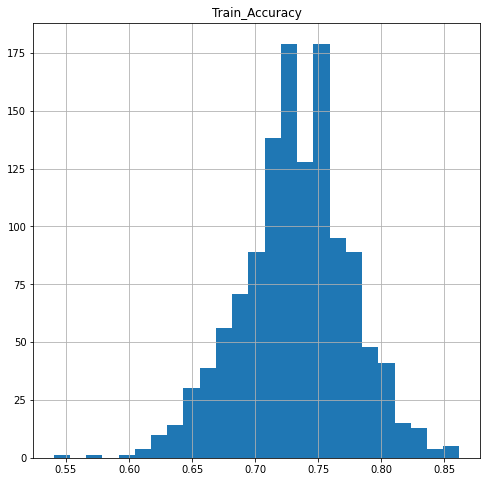

In [ ]:
%%time
# 6. Let's explore the impact of random train-test-splits on mean CV accuracy
cvf = 5 #number of folds per iteration
itr = 250 # number of iterations #### WARNING: I'm fitting the model 250 x 5 folds = 1250 times here! That can take a VERY LONG TIME with bigger data and more complex models!

# 7. Set-up dataframe to hold results and instantiate our model
acc = pd.DataFrame(columns=['5CV_Accuracies', 'MeanAccuracy', 'StD', 'Test_Accuracy']) # set-up dataframe with columns for variables of interest
cvsvm = SVC(C=100, gamma=0.25, kernel='poly') # instantiate model

# 8. Loop over splitting the data, fitting the model with CV, saving the model CV performance, predicting test data, evaluating test performance and saving it
for i in range(1,itr+1): 
    X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.25, stratify=y) # no random seed = different random splits
    cv_results = cross_val_score(cvsvm, X_train, y_train, cv=cvf) # CV of model
    cvsvm.fit(X_train, y_train) # fit model to entire train data
    y_pred = cvsvm.predict(X_test) # predict test data
    acc.loc[len(acc.index)] = [cv_results, round(cv_results.mean()*100,2), round(cv_results.std()*100,2),round(accuracy_score(y_test, y_pred)*100,2)] #put performance results in dataframe
    if i % 10 == 0: print(f"{i*cvf} models fitted and evaluated ...") # print status: every iteration that is evenly divisible by 10

# 9. Create Historgram of Model performance with 5-Fold CV at different train-test-splits
allACC = pd.DataFrame(np.concatenate(acc['5CV_Accuracies'].to_numpy()).ravel(), columns=['Train_Accuracy']) #I'm putting the arrays that contain the accuracies of each fold of each run in the loop into a new dataframe
hist = allACC.hist(column='Train_Accuracy',bins=25,figsize=(8,8))  

# 10. Print Mean and Standard Deviation
print(f"\nMean Train CV Accuracy is {round(allACC.Train_Accuracy.mean()*100,2)}% with Standard Deviation of {round(allACC.Train_Accuracy.std()*100,2)}%")

Mean Test Accuracy is 74.08% with Standard Deviation of 3.12%



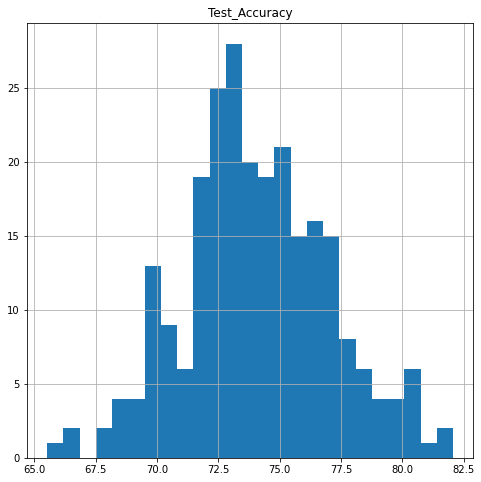

In [ ]:
# 11. Let's look at the Accuracies across different test sets
print(f"Mean Test Accuracy is {round(acc.Test_Accuracy.mean(),2)}% with Standard Deviation of {round(acc.Test_Accuracy.std(),2)}%\n")
hist = acc.hist(column='Test_Accuracy',bins=25,figsize=(8,8))  

---------

> Again, you could also use the entire data for CV. ***When and Why?***

# 4. Hyperparameter tuning

Most models have a number of parameters that need to be set. 
These are commonly referred to as **Hyperparameters**.  

*How should you set Hyperparameters?*

- k-Nearest Neighbors: n_neighbors (i.e., k), etc.
- Support Vector Machines: C and Gamma, etc.
- Random Forest: n_estimates, max_depth, max_features, etc.
- ***Hyperparameters cannot be learned by fitting the model***

***Unfortunately, there is no "one-size-fits-all" approach!***   

Why?

#### Choosing the best Hyperparameter
- Try a bunch of different hyperparameter values
- Fit all of them separately
- See how well each performs
- Choose the best performing one
- It is essential to use cross-validation!!!

*Let's fit a different model to our data:* **A Random Forest**

## 4.1 Manual Hyperparameter tuning

- Let's tune a Random Forest Classifier
   - Number of Trees: n_estimators
   - Tree depth: max_depth
   - Features to select from at each node: max_features


In [ ]:
# 1 Let's tune the Hyperparameters of a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# 2 Split our data again and seed the random number generator to ensure consistent results
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y, test_size=0.25, stratify=y, random_state=23)

# 3 Instantiate Model (i.e., define it)
rfbase = RandomForestClassifier(n_estimators = 25, max_depth = 25, max_features = 3, random_state=23)

# 4 Fit Model
rfbase.fit(X_train, y_train)

# 5 Make Prediction on test data
y_pred = rfbase.predict(X_test)

# 6 Output the accuracy of our prediction
from sklearn.metrics import accuracy_score
print(f"Accuracy of Random Forest Classifier on Training Data is {round(accuracy_score(y_train, rfbase.predict(X_train))*100,2)}%")
print(f"Accuracy of Random Forest Classifier on Testing Data is {round(accuracy_score(y_test, y_pred)*100,2)}%")

Accuracy of Random Forest Classifier on Training Data is 99.77%
Accuracy of Random Forest Classifier on Testing Data is 77.24%


## 4.2 Grid-Search for Hyperparameter tuning

* We can see that we have improved our model as we have added features and trained new models.
* At the point that we feel comfortable with a good model, we can start to tune the parameters of the model.
* There are a number of ways to do this (e.g., by manually trying different model parameters)
* An automated technique is called **Grid-Search** (essentially a *brute-force* search for optimal hyperparameters)

#### Important Note

- How well can the model perform on never before seen data?
- Using ALL data for cross-validation is not ideal
- Split data into training and hold-out set at the beginning
- Perform grid search cross-validation on training set
- Choose best hyperparameters and evaluate on hold-out set (i.e., test set)

In [ ]:
%%time
# GridSearchCV for a Random Forest
# Grid search is a 'brute force' search, one that will explore every possible combination of parameters that you provide it

# 1 Import Grid Search with Cross Validation
from sklearn.model_selection import GridSearchCV

# 2 First decide on the model to use and instantiate it 
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=23)

# Create a range of values to test for the "n_estimators" hyperparameter
n_estimators_range = np.arange(1, 101, 10)

# Define the range of values to test for the "max_depth" hyperparameter
max_depth_range = np.arange(1, 11)

# Define the range of values to test for the "max_features" hyperparameter
max_feature_range = np.arange(1, 11)

# 3 Then define the parameters we want to search as a dictionary. Explore the documentation to what other options are available
params = {'n_estimators': n_estimators_range, 'max_depth' : max_depth_range, 'max_features' : max_feature_range}

# 3 Then define the parameters we want to search as a dictionary. Explore the documentation to what other options are available
# params = {'n_estimators': [5, 10, 25, 50, 100], 'max_depth' : [5, 10, 25, 50], 'max_features' : [3, 5, 7]}

# 4 Next, create a grid search object with our chosen model and parameters. 
grid = GridSearchCV(rf, params, cv=5, n_jobs=-1, verbose=3)

# 5 Fit our model to the data as before
grid.fit(X_train, y_train)

# 6 Output of the grid search function: get the best_estimator - the model and parameters that scored best on the training data - 
#   and save it as a new a model
best_model = grid.best_estimator_
print(f"Best Paramaters are: {grid.best_params_}")

# 7. Examine model performance
print(f"Mean CV Accuracy of best Random Forest Classifier is {round(grid.best_score_*100,2)}%")

# 8 Now we use the best estimator to predict 
y_pred = best_model.predict(X_test)

# 9 Output the accuracy of our prediction
from sklearn.metrics import accuracy_score
print(f"Best Estimator Accuracy on Test Data is {round(accuracy_score(y_test, y_pred)*100,2)}% \n")

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Best Paramaters are: {'max_depth': 5, 'max_features': 5, 'n_estimators': 21}
Mean CV Accuracy of best Random Forest Classifier is 81.29%
Best Estimator Accuracy on Test Data is 85.52% 

CPU times: user 10.1 s, sys: 582 ms, total: 10.7 s
Wall time: 7min 11s


**An exhaustive search of the parameter grid can take a long time.** Particularly:
- when there are many parameters to tune
- when these parameters can assume many different values
- on a slow computer (or limited virtual environment, like free CoLab)

***To speed things up***: Use RandomizedSearchCV. 

In contrast to `GridSearchCV`, not all parameter values are tried, but rather a fixed number of parameter settings is sampled from specified distributions. The number of parameter settings that are tried is given by `n_iter`.

In [ ]:
%%time
# RandomizedSearchCV for a Random Forest
# The number of parameter settings that are tried is given by n_iter.

# 1. First, import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# 2. Define search space
param_grid = {'n_estimators': [5, 10, 25, 50, 100], 'max_depth' : [5, 10, 25, 50], 'max_features' : [3, 5, 7]}

# 3. Instatiante base estimator
rf = RandomForestClassifier(random_state=23)

# 4. Instantiate Search Model
search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=15, n_jobs=-1, cv=5, verbose=3)

# 5. Fit the model (i.e., train it on training data)
search.fit(X_train, y_train);

# 6. Output optimal Hyperparameter combination
print(f"Best Parameters are: {search.best_params_}")

# 7. Examine model performance
print(f"Mean CV Accuracy of best Random Forest Classifier is {round(search.best_score_*100,2)}%")

# 8 Now we use the best estimator to predict 
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

# 9 Output the accuracy of our prediction
from sklearn.metrics import accuracy_score
print(f"Best Estimator Accuracy on Test Data is {round(accuracy_score(y_test, y_pred)*100,2)}% \n")


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best Parameters are: {'n_estimators': 10, 'max_features': 3, 'max_depth': 5}
Mean CV Accuracy of best Random Forest Classifier is 81.98%
Best Estimator Accuracy on Test Data is 81.38% 

CPU times: user 155 ms, sys: 17.1 ms, total: 172 ms
Wall time: 4.57 s


# 5. The Problem with Accuracy: Confusion Matrices are Better!

Measuring model performance with Accuracy:  
- Fraction of correctly classified samples  
- Not always a useful metric  

### Where Accuracy fails:

![Party Accuracy](https://aprettiproblem.files.wordpress.com/2012/02/uncduke2.jpg "Accuracy Fails")

### Class imbalance example: Tarheel Party crashed by Blue Devils  
- Before Corona, 300 Tarheels had a great party until 3 Blue Devils managed to sneak in and cause trouble
- 99% of guests are Tarheels, 1% are Blue Devils 
- Could build a classifier that predicts almost perfectly whether some wanting to go to the party is a Tarheel: 99% Accuracy!
- But horrible at actually classifying guest as Blue Devils!  
- Fails at its original purpose  
- Need more nuanced metrics  

### Diagnosing classification predictions: The Confusion Matrix  

Act vs Pred  | Predicted: Devil | Predicted: Tarheel
--- | --- | ---
Actual: Devil | True Positive | False Negative
Actual: Tarheel | False Positive| True Negative

<p style="text-align: left; font-size:120%; font-weight: normal; font-style: normal;">
$Accuracy = \frac{t_p + t_n}{t_p + t_n + f_p + f_n}$ <br><br> 
$Precision = \frac{t_p}{t_p + f_p}$    <br><br>    
$Recall = \frac{t_p}{t_p + f_n}$   <br><br>    
$F1 score = 2 \times \frac{precision \times recall}{precision + recall}$ 
</p>

**Precision** is intuitively the ability of the classifier not to label as positive a sample that is negative
- High Precision: Not many Tarheels predicted as Devils  

**Recall** is intuitively the ability of the classifier to find all the positive samples.
- High Recall: Predicted most Devils correctly 

**The F1 score** is the harmonic mean of the precision and recall:
- where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.


Accuracy of best Random Forest Classifier is 81.38%
              precision    recall  f1-score   support

           0       0.91      0.44      0.60        45
           1       0.80      0.98      0.88       100

    accuracy                           0.81       145
   macro avg       0.85      0.71      0.74       145
weighted avg       0.83      0.81      0.79       145



Text(0.5, 15.0, 'Predicted')

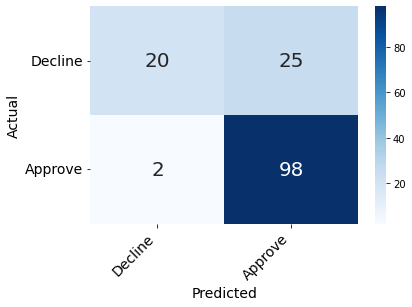

In [ ]:
# Generate the confusion matrix and classification report

# 1 First, import confusion matrix and classification report from sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 2 Show the accuracy of our prediction
print(f"Accuracy of best Random Forest Classifier is {round(accuracy_score(y_test, y_pred)*100,2)}%")

# 3 Show Classification Report
print(classification_report(y_test, y_pred))

# 4 Visualize the confusion matrix to make it easier to read
import seaborn as sns
import matplotlib.pyplot as plt
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Decline', 'Approve'), ('Decline', 'Approve'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

**Precision** is intuitively the ability of the classifier not to label as positive a sample that is negative

**Recall** is intuitively the ability of the classifier to find all the positive samples.

**The F1 score** is the harmonic mean of the precision and recall

**Support** is the number of occurrences of each class in the "ground truth" (i.e., correct) target values.

**Averages** include:
- macro average (averaging the unweighted mean per label)
- weighted average (averaging the support-weighted mean per label)
- sample average (only for multilabel classification)

> **What matters more to the Fintech:** Precision or Recall?

# 6. Binary Outputs vs. Probabilities

In a classification problem, we ***may decide to predict the class values directly***. For example, the customer is eligible for a loan or not (Y vs. N or 1 vs. 0)

Alternately, it can be ***more flexible to predict the probabilities for each class instead***.    

The reason for this is to ***provide the capability to choose and even calibrate the threshold*** for how to interpret the predicted probabilities.

For example, by default we might use a threshold of 0.5, meaning that:
- a probability 0.0 >= *P* < 0.5 is a negative outcome (0)
- a probability from 0.5 >= p <= 1.0 is a positive outcome (1)  

***This threshold can be adjusted*** to tune the behavior of the model for a specific problem. An example would be to reduce more of one or another type of error.

**>>Take-Away<<**: We can change this threshold if, for example, we require a higher confidence to take a certain action such as giving out a loan.

In [ ]:
# 1a Show binary classes
y_pred = best_model.predict(X_test)
#print(y_pred)

# 1b Show probabilities
probs = best_model.predict_proba(X_test)[:, 1]
#print(probs)

# 1c Show them together for those where probabilities are closer to 0.5
results= pd.DataFrame({'classes':y_pred, 'probabilities':probs})
results[(results.probabilities >.3) & (results.probabilities <.7)]


,classes,probabilities
2,1,0.698147
5,1,0.676165
8,0,0.333983
9,0,0.348131
18,1,0.694746
20,1,0.692060
24,1,0.678328
30,1,0.667191
32,1,0.685383
36,0,0.311151


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
# 2a Set threshold level
#threshold = 0.7

# 2a better. Threshold tuning
threshold = [0.3, 0.5, 0.7]
for threshold in threshold:
    predicted = (best_model.predict_proba(X_test)[:, 1] >= threshold).astype(int)
    print(f"Threshold @{round(threshold*100,2)}%: Precision {round(precision_score(y_test, predicted)*100,2)}%  Recall {round(recall_score(y_test, predicted)*100,2)}% F1 Score {round(f1_score(y_test, predicted)*100,2)}%")

# 2b Get probabilities from model
probs = best_model.predict_proba(X_test)[:, 1]

# 2c Assign prediction classes using new threshold 
predicted = (probs >= threshold).astype('int')

# 2d Evaluate prediction
print(f"Threshold @{round(threshold*100,2)}%: Accuracy {round(accuracy_score(y_test, predicted)*100,2)}%  Precision {round(precision_score(y_test, predicted)*100,2)}%  Recall {round(recall_score(y_test, predicted)*100,2)}%")
print(f"Threshold @50.0%: Accuracy {round(accuracy_score(y_test, y_pred)*100,2)}%  Precision {round(precision_score(y_test, y_pred)*100,2)}%  Recall {round(recall_score(y_test, y_pred)*100,2)}%")

Threshold @30.0%: Precision 76.92%  Recall 100.0% F1 Score 86.96%
Threshold @50.0%: Precision 82.64%  Recall 100.0% F1 Score 90.5%
Threshold @70.0%: Precision 84.91%  Recall 90.0% F1 Score 87.38%
Threshold @70.0%: Accuracy 82.07%  Precision 84.91%  Recall 90.0%
Threshold @50.0%: Accuracy 85.52%  Precision 82.64%  Recall 100.0%


              precision    recall  f1-score   support

           0       0.74      0.64      0.69        45
           1       0.85      0.90      0.87       100

    accuracy                           0.82       145
   macro avg       0.80      0.77      0.78       145
weighted avg       0.82      0.82      0.82       145



Text(0.5, 10.0, 'Predicted')

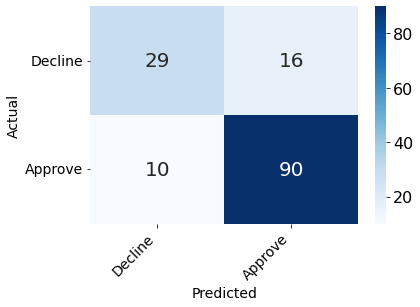

In [ ]:
# 3 Output Classification Report
print(classification_report(y_test, predicted))

# 4 Visualize the confusion matrix to make it easier to read
con_matrix = confusion_matrix(y_test, predicted)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Decline', 'Approve'), ('Decline', 'Approve'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

##### ***We can check the trade-off between precision and recall visually by plotting how they change across different thresholds***

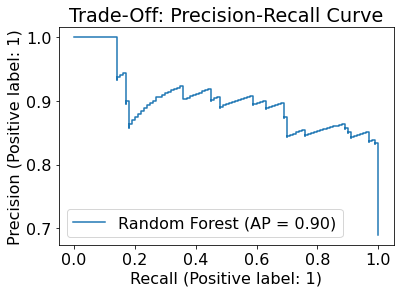

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test, name="Random Forest")
_ = display.ax_.set_title("Trade-Off: Precision-Recall Curve")

# 7. Receiver Operating Characteristic (ROC) Curves
Classification reports and confusion matrices are great methods to quantitatively evaluate model performance.

**ROC curves provide a way to visually evaluate models**  
- Commonly used graph that summarizes the performance of a classifier over all possible thresholds
- Generated by plotting the True Positive Rate (y-axis) against the False Positive Rate (x-axis)...
- ... as we vary the threshold for assigning customers to a given segment 
  
   

- ROC visually compares ***signal*** (True Positive Rate) against ***noise*** (False Positive Rate)
- Model performance is determined by inspecting the area under the ROC curve (or AUC)   
- Best possible AUC is 1
- Worst possible AUC is 0.5 (the 45 degree random line) 

**>>Question<<:** What would a AUC less than 0.5 tell us?  

*Many classifiers in scikit-learn have a .predict_proba() method which returns the probability of a given sample being in a particular class.*

#### Having built a Random Forest model, we can now evaluate its performance by plotting an ROC curve. 
- We will use of the .predict_proba() method and become familiar with its functionality.
- We start by defining a function that caculates the AUC for training and test set as well as visualizes the ROC curve in a plot


In [ ]:
# 1 Import ROC_curve and roc_auc_score from sklearn
from sklearn.metrics import roc_auc_score, roc_curve

# 2 Let's create a function that allows us to quickly and conveniently evaluate ROC and AUC for Classifier Predictions 
#   (this function might come in handy one day)

'Function that evaluates ROC and AUC'
def evaluate_model(train_props,y_train,test_probs,y_test):
  # 2a Calcualte AUC
  train_AUC = round(roc_auc_score(y_train, train_probs),2)
  test_AUC = round(roc_auc_score(y_test, test_probs),2)
  base_AUC = round(roc_auc_score(y_test, [1 for _ in range(len(y_test))]),2)

  # 2b Print to screen
  print(f'Baseline ROC AUC: {base_AUC}')
  print(f'Test ROC AUC Score: {test_AUC}')
  print(f'Train ROC AUC Score: {train_AUC}')

  # 2c Calculate false positive rates and true positive rates
  base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
  test_model_fpr, test_model_tpr, _ = roc_curve(y_test, test_probs)
  train_model_fpr, train_model_tpr, _ = roc_curve(y_train, train_probs)

  # 2d Plot both curves
  plt.figure(figsize = (8, 6))
  plt.rcParams['font.size'] = 16
  plt.plot(base_fpr, base_tpr, 'b', label = 'Baseline')
  plt.plot(test_model_fpr, test_model_tpr, 'r', label = 'Test')
  plt.plot(train_model_fpr, train_model_tpr, 'g', label = 'Train')
  plt.legend();
  plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
  return

Baseline ROC AUC: 0.5
Test ROC AUC Score: 0.96
Train ROC AUC Score: 0.96


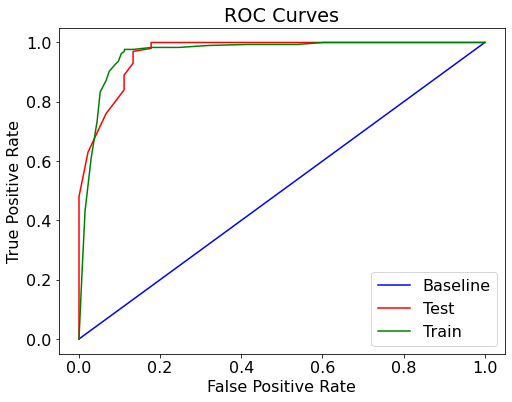

In [ ]:
## Let's evaluate our Original Random Forest Tree's performance using AUC

# 3a Get probabilities for training and testing
train_probs = rfbase.predict_proba(X_train)[:, 1]
test_probs = rfbase.predict_proba(X_test)[:, 1]

# 3b Evaluate
evaluate_model(train_probs,y_train,test_probs,y_test)

Baseline ROC AUC: 0.5
Test ROC AUC Score: 0.84
Train ROC AUC Score: 0.92


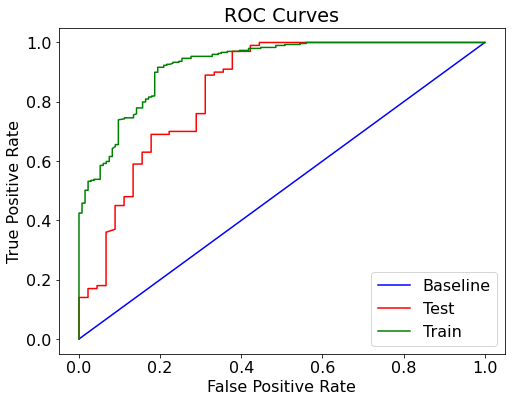

In [ ]:
## Let's evaluate our Best Model Random Forest Tree's performance using AUC

# 4a Get probabilities for training and testing
train_probs = best_model.predict_proba(X_train)[:, 1]
test_probs = best_model.predict_proba(X_test)[:, 1]

# 4b Evaluate
evaluate_model(train_probs,y_train,test_probs,y_test)

# 8. Algorithmic Bias

- Unjust, unfair, or prejudicial treatment of people
- Related to race, income, sexual orientation, religion, gender
- And other characteristics historically associated with discrimination and marginalization
- When and where they manifest in algorithmic systems or algorithmically aided decision-making



---


*“Although neural networks might be said to write their own programs, they do so towards ***goals set by humans, using data collected for human purposes***. 
If the data is skewed, even by accident, the computers will ***amplify injustice***.”*  


— The Guardian  
https://www.theguardian.com/commentisfree/2016/oct/23/the-guardian-view-on-machine-learning-people-must-decide


---


**Can we find evidence that our model is biased?**  

What about gender bias and loan eligibility?

## 8.1 Testing for Fairness & Inclusion in Binary Classification

**Disaggregated Evaluation**
- Create for each (subgroup, prediction) pair
- Compare across subgroups  

*Example* 
- Women, approve loan
- Men, approve loan


**Intersectional Evaluation**
- Create for each (subgroup1, subgroup2, prediction) pair
- Compare across subgroups

*Example* 
- Women with children, approve loan
- Men without children, approve loan



## 8.2 Inspect Confusion Matrices

In [ ]:
# 1a Identify Female and Male applicants in Test Set
idxM=X_test.index[X_test['Gender_Male'] == 1].tolist()
idxF=X_test.index[X_test['Gender_Female'] == 1].tolist()
print(f"Test cases for Males: {len(idxM)}")
print(f"Test cases for Females: {len(idxF)}")

# 1b Now predict for Females and Males separately 
y_predF = best_model.predict(X_test.loc[idxF])
y_predM = best_model.predict(X_test.loc[idxM])

Test cases for Males: 120
Test cases for Females: 25


Text(0.5, 10.0, 'Predicted')

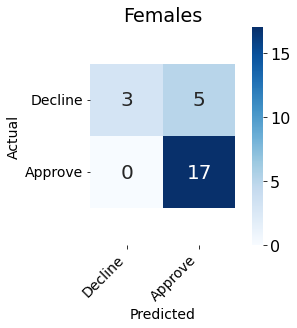

In [ ]:
# 2a Confusion Matrix for Females
con_matrix = confusion_matrix(y_test.loc[idxF], y_predF)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Decline', 'Approve'), ('Decline', 'Approve'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues",square=True)
bottom, top = heatmap.get_ylim()
heatmap.set_ylim(bottom + 0.5, top - 0.5)
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
heatmap.set_title('Females')
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

Text(0.5, 10.0, 'Predicted')

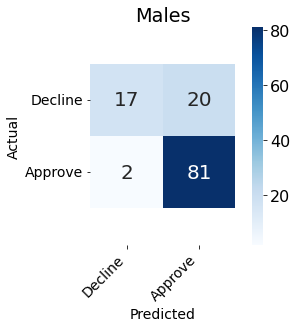

In [ ]:
# 2b Confusion Matrix for Males
con_matrix = confusion_matrix(y_test.loc[idxM], y_predM)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Decline', 'Approve'), ('Decline', 'Approve'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues",square=True)
bottom, top = heatmap.get_ylim()
heatmap.set_ylim(bottom + 0.5, top - 0.5)
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
heatmap.set_title('Males')
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

**Remember the definitions of Precision, Recall and F1 Score from Section 5?**

**Precision** is intuitively the ability of the classifier not to label as positive a sample that is negative

**Recall** is intuitively the ability of the classifier to find all the positive samples.

**The F1 score** is the harmonic mean of the precision and recall

## 8.3 Equality of Opportunity 

**Fairness criterion:**   
- *Recall* is equal across subgroups
- We should grant the loan to an equal proportion of applicants from the qualified fraction of each subgroup

In [ ]:
# 0 Import precision and recall scores from sklearn
from sklearn.metrics import precision_score, recall_score

# 1 Let's compare recall
print(f"Recall for Females: {recall_score(y_test.loc[idxF], y_predF)}")
print(f"Recall for Males:   {recall_score(y_test.loc[idxM], y_predM)}")

Recall for Females: 1.0
Recall for Males:   0.9759036144578314


## 8.4 Predictive Parity 

**Fairness criterion:**
- *Precision* is equal across subgroups
- 
A prediction for an applicant should reflect the candidate’s real eligibility for their loan

In [ ]:
# 2 Let's compare precision
print(f"Precision for Females: {precision_score(y_test.loc[idxF], y_predF)}")
print(f"Precision for Males:   {precision_score(y_test.loc[idxM], y_predM)}")

Precision for Females: 0.7727272727272727
Precision for Males:   0.801980198019802


---

*Even if we don't find evidence for a bias against men or women,*  
*this does not mean that there isn't any bias.*  
    
> **Why?**


---



# **Looking Ahead:**  

###**Next Class:** Thursday, March 9, 2023  

####***Predictive Modelling III***

**Read before class:**  Neslin, S.A., Gupta, S., Kamakura, W., Lu, J. and Mason, C.H., 2006. Defection detection: [Measuring and understanding the predictive accuracy of customer churn models](https://kenan-flagler.instructure.com/files/250306187/download?download_frd=1) . Journal of Marketing Research, 43(2), pp. 204-211.   

--------
###**After Spring Break:** Tuesday, March 21, 2023  

#### ***Customer Churn*** *- Who to keep and who to let go?*
 - **IMPORTANT**: Download Class 18 Notebook and data from Canvas ***before*** class and ***run*** entire notebook on CoLab. 
 - **TAKE A CLOSE LOOK** at what the notebook does and what insights it produces. 
 - **BE PREPARED** to discuss the notebook in class!

